In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from pathlib import Path
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.patches as mpatches


In [2]:
base_dir= Path.cwd().parent
data_dir = base_dir/"data"
raw = data_dir/"raw"
processed = data_dir/"processed"

In [3]:
df = pd.read_csv(
    processed/"master_monthly.csv",
     parse_dates=["date"], dayfirst=True)
df = df.sort_values("date").reset_index(drop=True)
df.head()

,date,fx_rate,dxy,us10y_nominal,us10y_real,fx_reserves
0,1985-04-01,12.400455,149.610909,11.434762,NaN,6.374355e+09
1,1985-05-01,12.500455,149.955000,10.846818,NaN,6.271733e+09
2,1985-06-01,12.440500,147.713000,10.156000,NaN,6.198352e+09
3,1985-07-01,12.031364,141.006364,10.306818,NaN,6.063375e+09
4,1985-08-01,11.897727,137.558636,10.331818,NaN,6.005903e+09


In [4]:
print("Rows:", len(df))
print("Start Date:", df["date"].min())
print("End Date:", df["date"].max())
print("Duplicate dates:", df["date"].duplicated().sum())

Rows: 489
Start Date: 1985-04-01 00:00:00
End Date: 2025-12-01 00:00:00
Duplicate dates: 0


In [5]:
df.columns

Index(['date', 'fx_rate', 'dxy', 'us10y_nominal', 'us10y_real', 'fx_reserves'], dtype='object')

In [6]:
df["fx_rate"] = pd.to_numeric(df["fx_rate"], errors="coerce")
print("Missing INR values:", df["fx_rate"].isna().sum())

Missing INR values: 0


In [7]:
df["inr_dep_mom"] = df["fx_rate"].pct_change()

In [8]:
df["inr_dep_12m"] = df["fx_rate"].pct_change(12)

In [9]:
df["inr_dep_36m"] = df["fx_rate"].pct_change(36)

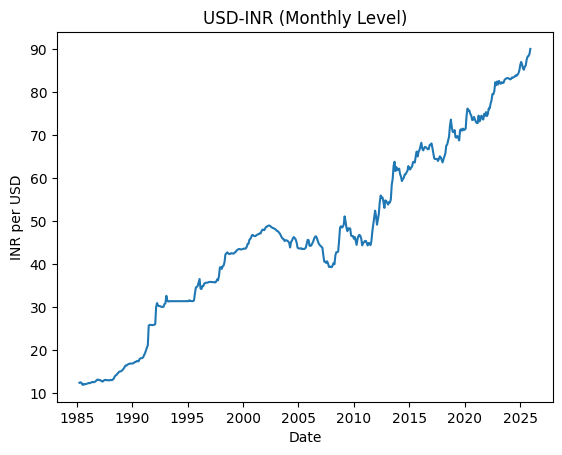

In [10]:
plt.figure()
plt.plot(df["date"], df["fx_rate"])
plt.title("USD-INR (Monthly Level)")
plt.xlabel("Date")
plt.ylabel("INR per USD")
plt.show()

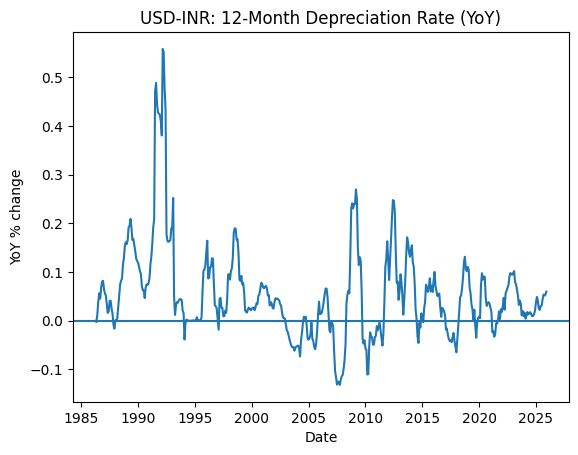

In [11]:
plt.figure()
plt.plot(df["date"], df["inr_dep_12m"])
plt.axhline(0)
plt.title("USD-INR: 12-Month Depreciation Rate (YoY)")
plt.xlabel("Date")
plt.ylabel("YoY % change")
plt.show()

In [12]:
s = df["inr_dep_12m"].dropna()
print("Mean YoY depreciation:",round(s.mean(),3))
print("Median:", round(s.median(),3))
print("Std dev:", round(s.std(),3))
print("\nPercentiles:")
for p in [5,10,25,50,75,90,95]:
    print(f"{p}%:", round(np.percentile(s,p),3))

Mean YoY depreciation: 0.055
Median: 0.038
Std dev: 0.096

Percentiles:
5%: -0.054
10%: -0.039
25%: 0.001
50%: 0.038
75%: 0.087
90%: 0.162
95%: 0.209


In [13]:
latest_dep = s.iloc[-1]
print("Latest YoY depreciation:", round(latest_dep, 3))
pct_rank = percentileofscore(s, latest_dep, kind="weak")
print("\nLatest observation percentile:", round(pct_rank, 1))


Latest YoY depreciation: 0.06

Latest observation percentile: 62.9


In [14]:
p95 = np.percentile(s, 95)
df["stress_flag"] = df["inr_dep_12m"] >= p95

print("95th percentile YoY depreciation:", round(p95, 3))
print("Number of stress months:", df["stress_flag"].sum())

95th percentile YoY depreciation: 0.209
Number of stress months: 24


In [15]:
df.loc[
    df["stress_flag"],
    ["date", "fx_rate", "inr_dep_12m"]
    ].sort_values("inr_dep_12m", ascending=False).head(20)

,date,fx_rate,inr_dep_12m
83,1992-03-01,30.018091,0.558425
84,1992-04-01,30.933500,0.551966
76,1991-08-01,25.875409,0.488648
85,1992-05-01,30.377000,0.477581
75,1991-07-01,25.669087,0.471928
77,1991-09-01,25.854190,0.445373
86,1992-06-01,30.249091,0.434150
78,1991-10-01,25.818391,0.428403
79,1991-11-01,25.815095,0.425414
80,1991-12-01,25.837136,0.423134


In [16]:
df.to_csv(processed/"inr_stress_test.csv", index=False)

In [17]:
monthly = pd.read_csv(
    processed/"master_monthly.csv",
     parse_dates=["date"], dayfirst=True)
cpi = pd.read_csv(
    processed/"master_yearly.csv",
     parse_dates=["date"], dayfirst=True)

In [18]:
monthly["year"] = monthly["date"].dt.year
usd_inr_annual = (
    monthly
    .groupby("year", as_index=False)["fx_rate"]
    .mean()
)

In [19]:
cpi["year"] = cpi["date"].dt.year
cpi["inflation_diff"] = cpi["cpi_india"] - cpi["cpi_us"]
cpi.head()

,date,cpi_india,cpi_us,year,inflation_diff
0,1985-01-01,5.556424,3.545644,1985,2.010780
1,1986-01-01,8.729721,1.898048,1986,6.831673
2,1987-01-01,8.801126,3.664563,1987,5.136563
3,1988-01-01,9.383472,4.077741,1988,5.305731
4,1989-01-01,7.074280,4.827003,1989,2.247277


In [20]:
annual = (
    usd_inr_annual
    .merge(
        cpi[["year", "cpi_india", "cpi_us", "inflation_diff"]],
        on="year",
        how="inner"
    )
)
annual.head()

,year,fx_rate,cpi_india,cpi_us,inflation_diff
0,1985,12.186957,5.556424,3.545644,2.010780
1,1986,12.598612,8.729721,1.898048,6.831673
2,1987,12.947774,8.801126,3.664563,5.136563
3,1988,13.902823,9.383472,4.077741,5.305731
4,1989,16.196733,7.074280,4.827003,2.247277


In [21]:
annual["inr_dep_yoy"] = annual["fx_rate"].pct_change()

In [22]:
annual["cum_inr_dep"] = (1 + annual["inr_dep_yoy"]).cumprod() - 1
annual["cum_inflation_diff"] = (1 + annual["inflation_diff"]/100).cumprod() - 1

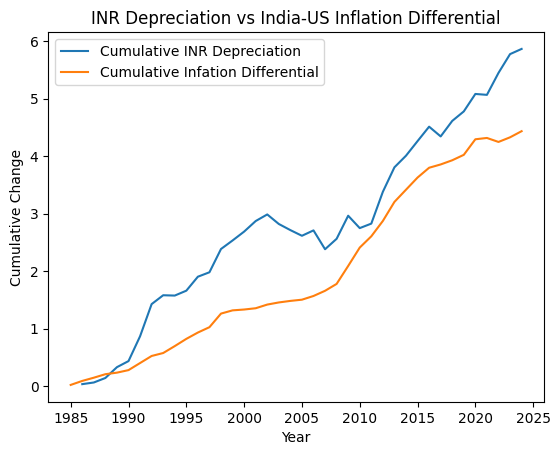

In [23]:
plt.figure()
plt.plot(annual["year"], annual["cum_inr_dep"], label="Cumulative INR Depreciation")
plt.plot(annual["year"], annual["cum_inflation_diff"], label="Cumulative Infation Differential")

plt.title("INR Depreciation vs India-US Inflation Differential")
plt.xlabel("Year")
plt.ylabel("Cumulative Change")
plt.legend()
plt.show()

In [24]:
annual.loc[
    annual["year"].isin([1991, 2000, 2010, 2020, annual["year"].max()]),
    ["year", "cum_inr_dep", "cum_inflation_diff"]
    ]


,year,cum_inr_dep,cum_inflation_diff
6,1991,0.866432,0.400882
15,2000,2.687017,1.331646
25,2010,2.747872,2.409161
35,2020,5.081424,4.293064
39,2024,5.864708,4.433855


In [25]:
annual["excess_dep"] = annual["inr_dep_yoy"] - (annual["inflation_diff"] / 100)

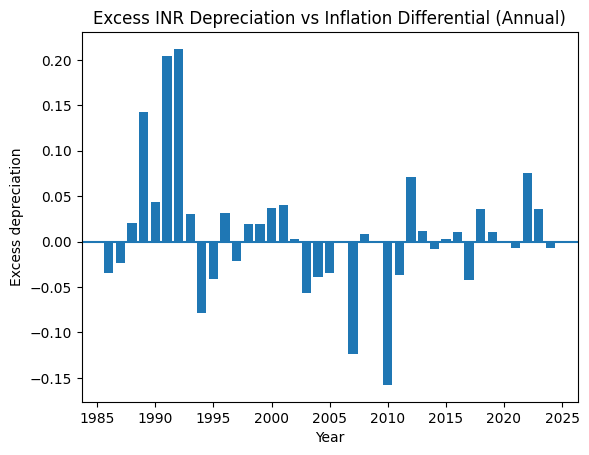

In [26]:
plt.figure()
plt.bar(annual["year"], annual["excess_dep"])
plt.axhline(0)
plt.title("Excess INR Depreciation vs Inflation Differential (Annual)")
plt.xlabel("Year")
plt.ylabel("Excess depreciation")
plt.show()

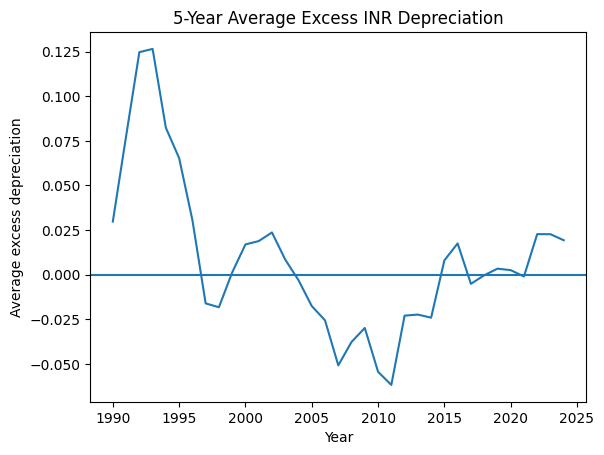

In [27]:
annual["excess_dep_5y_avg"] = annual["excess_dep"].rolling(5).mean()

plt.figure()
plt.plot(annual["year"], annual["excess_dep_5y_avg"])
plt.axhline(0)
plt.title("5-Year Average Excess INR Depreciation")
plt.xlabel("Year")
plt.ylabel("Average excess depreciation")
plt.show()


In [28]:
monthly = pd.read_csv(
    processed/"master_monthly.csv",
     parse_dates=["date"], dayfirst=True
).sort_values("date").reset_index(drop=True)

In [29]:
for col in ["fx_rate", "dxy", "us10y_real"]:
    monthly[col] = pd.to_numeric(monthly[col], errors="coerce")

In [30]:
monthly["inr_dep_12m"] = monthly["fx_rate"].pct_change(12)

In [31]:
base = monthly.dropna(subset=["inr_dep_12m", "dxy"]).iloc[0]

monthly["dxy_indexed"] = monthly["dxy"] / base["dxy"] * 100
monthly["usd_inr_indexed"] = monthly["fx_rate"] / base["fx_rate"] * 100

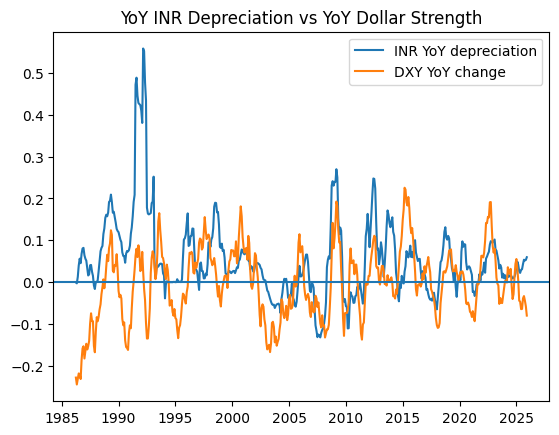

In [32]:
monthly["usd_inr_12m"] = monthly["fx_rate"].pct_change(12)
monthly["dxy_12m"] = monthly["dxy"].pct_change(12)

plt.figure()
plt.plot(monthly["date"], monthly["usd_inr_12m"], label="INR YoY depreciation")
plt.plot(monthly["date"], monthly["dxy_12m"], label="DXY YoY change")
plt.axhline(0)
plt.legend()
plt.title("YoY INR Depreciation vs YoY Dollar Strength")
plt.show()

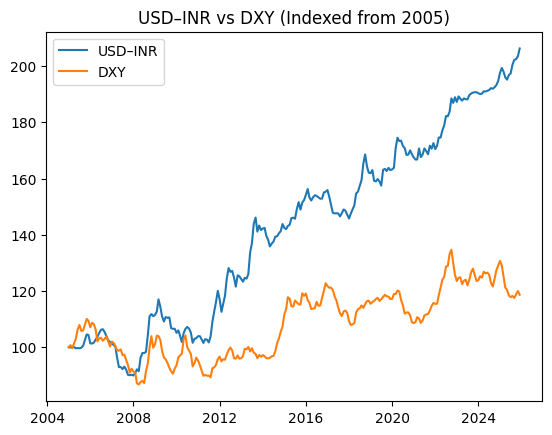

In [33]:
window = monthly[monthly["date"] >= "2005-01-01"].copy()

window["usd_inr_idx"] = window["fx_rate"] / window["fx_rate"].iloc[0] * 100
window["dxy_idx"] = window["dxy"] / window["dxy"].iloc[0] * 100

plt.figure()
plt.plot(window["date"], window["usd_inr_idx"], label="USD–INR")
plt.plot(window["date"], window["dxy_idx"], label="DXY")
plt.legend()
plt.title("USD–INR vs DXY (Indexed from 2005)")
plt.show()


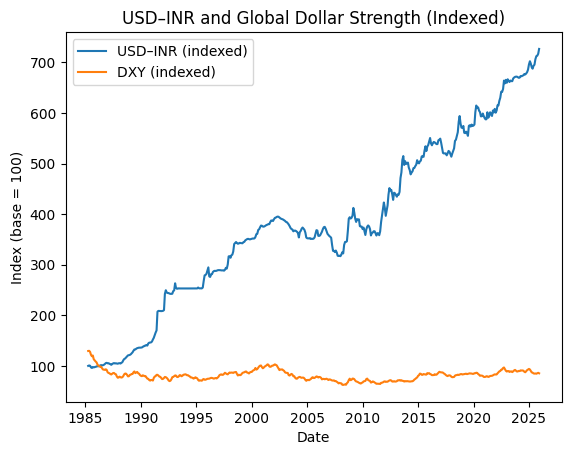

In [34]:
plt.figure()
plt.plot(monthly["date"], monthly["usd_inr_indexed"], label="USD–INR (indexed)")
plt.plot(monthly["date"], monthly["dxy_indexed"], label="DXY (indexed)")
plt.title("USD–INR and Global Dollar Strength (Indexed)")
plt.xlabel("Date")
plt.ylabel("Index (base = 100)")
plt.legend()
plt.show()


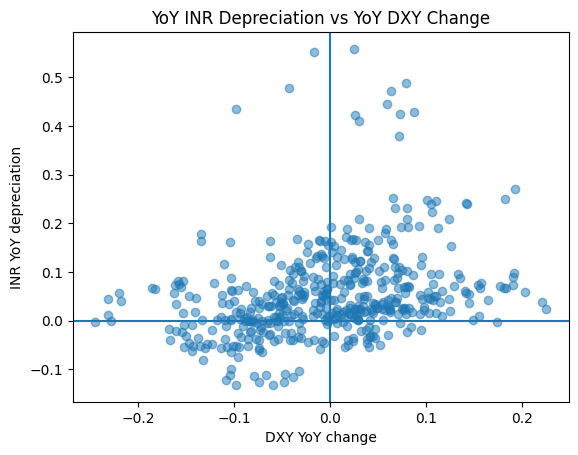

In [35]:
monthly["dxy_12m"] = monthly["dxy"].pct_change(12)

plt.figure()
plt.scatter(
    monthly["dxy_12m"],
    monthly["inr_dep_12m"],
    alpha=0.5
)
plt.axhline(0)
plt.axvline(0)
plt.title("YoY INR Depreciation vs YoY DXY Change")
plt.xlabel("DXY YoY change")
plt.ylabel("INR YoY depreciation")
plt.show()


In [36]:
quads = [
    (monthly["dxy_12m"] > 0) & (monthly["inr_dep_12m"] > 0), # Q1: Top-Right
    (monthly["dxy_12m"] < 0) & (monthly["inr_dep_12m"] > 0), # Q2: Top-Left
    (monthly["dxy_12m"] < 0) & (monthly["inr_dep_12m"] < 0), # Q3: Bottom-Left
    (monthly["dxy_12m"] > 0) & (monthly["inr_dep_12m"] < 0)  # Q4: Bottom-Right
]

quad_labels = ["Q1 (Upper-Right)", "Q2 (Upper-Left)", "Q3 (Bottom-Left)", "Q4 (Bottom-Right)"]
monthly["quadrant"] = np.select(quads, quad_labels, default="On Axis")

pop_counts = monthly["quadrant"].value_counts().drop("On Axis", errors='ignore')
most_populated = pop_counts.idxmax()
total_points = pop_counts.max()

print(f"The most populated quadrant is: {most_populated} with {total_points} points.")
print("\nFull Distribution:")
print(pop_counts)


The most populated quadrant is: Q1 (Upper-Right) with 211 points.

Full Distribution:
quadrant
Q1 (Upper-Right)     211
Q2 (Upper-Left)      155
Q3 (Bottom-Left)      84
Q4 (Bottom-Right)     27
Name: count, dtype: int64


In [37]:
subset = monthly[["dxy_12m", "inr_dep_12m"]].dropna()
corr_coef = subset["dxy_12m"].corr(subset["inr_dep_12m"])
print(f"Correlation between YoY DXY change and YoY INR depreciation: {corr_coef:.2f}")


Correlation between YoY DXY change and YoY INR depreciation: 0.31


In [38]:
ry = monthly.dropna(subset=["us10y_real", "inr_dep_12m"])

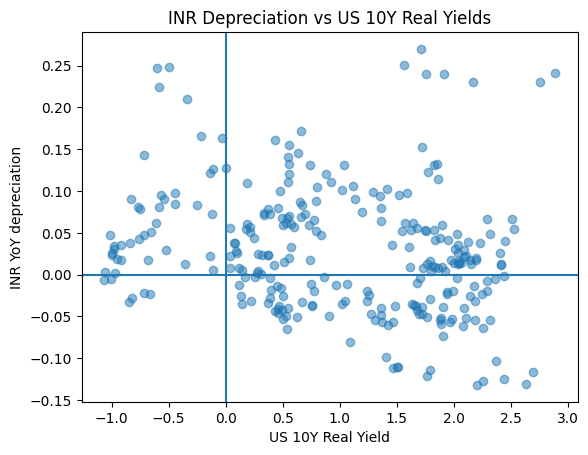

In [39]:
plt.figure()
plt.scatter(
    ry["us10y_real"],
    ry["inr_dep_12m"],
    alpha=0.5
)
plt.axhline(0)
plt.axvline(0)
plt.title("INR Depreciation vs US 10Y Real Yields")
plt.xlabel("US 10Y Real Yield")
plt.ylabel("INR YoY depreciation")
plt.show()


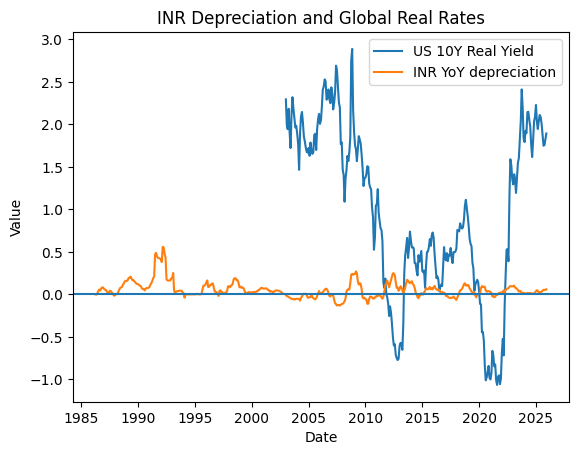

In [40]:
plt.figure()
plt.plot(monthly["date"], monthly["us10y_real"], label="US 10Y Real Yield")
plt.plot(monthly["date"], monthly["inr_dep_12m"], label="INR YoY depreciation")
plt.axhline(0)
plt.title("INR Depreciation and Global Real Rates")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


In [41]:
monthly["fx_reserves"] = pd.to_numeric(monthly["fx_reserves"], errors="coerce")


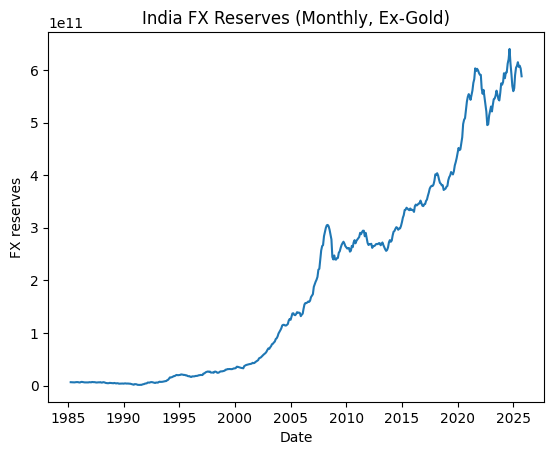

In [42]:
plt.figure()
plt.plot(monthly["date"], monthly["fx_reserves"])
plt.title("India FX Reserves (Monthly, Ex-Gold)")
plt.xlabel("Date")
plt.ylabel("FX reserves")
plt.show()


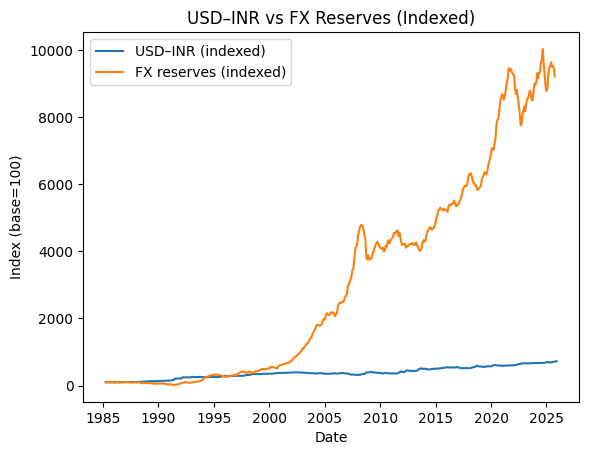

In [43]:
base_date = monthly.dropna(subset=["fx_reserves", "fx_rate"]).iloc[0]

monthly["reserves_idx"] = monthly["fx_reserves"] / base_date["fx_reserves"] * 100
monthly["usd_inr_idx"] = monthly["fx_rate"] / base_date["fx_rate"] * 100

plt.figure()
plt.plot(monthly["date"], monthly["usd_inr_idx"], label="USD–INR (indexed)")
plt.plot(monthly["date"], monthly["reserves_idx"], label="FX reserves (indexed)")
plt.title("USD–INR vs FX Reserves (Indexed)")
plt.xlabel("Date")
plt.ylabel("Index (base=100)")
plt.legend()
plt.show()


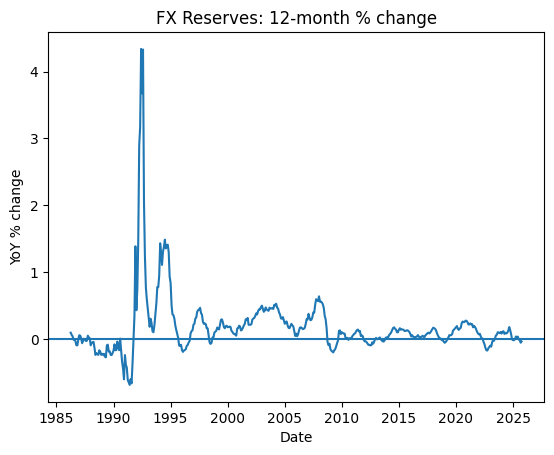

In [44]:
monthly["reserves_12m_change"] = monthly["fx_reserves"].pct_change(
    12,
    fill_method=None    
)

plt.figure()
plt.plot(monthly["date"], monthly["reserves_12m_change"])
plt.axhline(0)
plt.title("FX Reserves: 12-month % change")
plt.xlabel("Date")
plt.ylabel("YoY % change")
plt.show()


In [45]:
s = monthly["inr_dep_12m"].dropna()
p95 = np.percentile(s, 95)

monthly["inr_stress"] = monthly["inr_dep_12m"] >= p95
print("Stress threshold (95th percentile YoY depreciation):", round(p95, 3))
print("Stress months:", monthly["inr_stress"].sum())

Stress threshold (95th percentile YoY depreciation): 0.209
Stress months: 24


In [46]:
stress_res = monthly.loc[monthly["inr_stress"], "reserves_12m_change"].dropna()
normal_res = monthly.loc[~monthly["inr_stress"], "reserves_12m_change"].dropna()

print("Median reserves YoY change (stress months):", round(stress_res.median(), 3))
print("Median reserves YoY change (normal months):", round(normal_res.median(), 3))


Median reserves YoY change (stress months): -0.082
Median reserves YoY change (normal months): 0.1


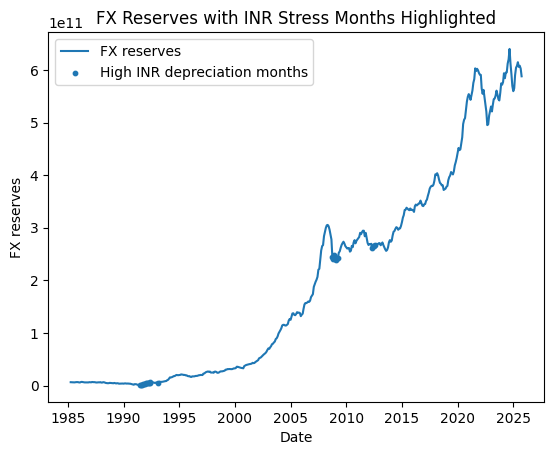

In [47]:
plt.figure()
plt.plot(monthly["date"], monthly["fx_reserves"], label="FX reserves")

stress_points = monthly[monthly["inr_stress"] & monthly["fx_reserves"].notna()]
plt.scatter(stress_points["date"], stress_points["fx_reserves"], s=10, label="High INR depreciation months")

plt.title("FX Reserves with INR Stress Months Highlighted")
plt.xlabel("Date")
plt.ylabel("FX reserves")
plt.legend()
plt.show()


In [48]:
monthly["date"] = pd.to_datetime(monthly["date"], dayfirst=True, errors="coerce")
monthly = monthly.sort_values("date").reset_index(drop=True)

#calculating volatility of the inr against usd

monthly["fx_logret"] = np.log(monthly["fx_rate"]).diff()
monthly["fx_vol_12m"] = monthly["fx_logret"].rolling(12).std() * np.sqrt(12)

In [49]:
sig = monthly[["date", "inr_dep_12m", "fx_vol_12m", "fx_reserves", "reserves_12m_change","fx_rate"]].copy()

pace_p95 = np.nanpercentile(sig["inr_dep_12m"], 95)
vol_p90  = np.nanpercentile(sig["fx_vol_12m"], 90)
vol_p95  = np.nanpercentile(sig["fx_vol_12m"], 95)
res_p10  = np.nanpercentile(sig["reserves_12m_change"], 10)

print("Depreciation rate @ 95th percentile:", pace_p95)
print("Volitality @ 90th percentile & @ 95th percentile:", vol_p90, vol_p95)
print("Reserves change 10th percentile:", res_p10)


Depreciation rate @ 95th percentile: 0.2093772562700671
Volitality @ 90th percentile & @ 95th percentile: 0.09088943589248528 0.10158189940594828
Reserves change 10th percentile: -0.1406956189237126


In [50]:
sig["pace_stress"] = sig["inr_dep_12m"] >= pace_p95
sig["vol_stress"]  = sig["fx_vol_12m"] >= vol_p90
sig["buf_stress"]  = sig["reserves_12m_change"] <= 0 

sig["stress_flag"] = sig["pace_stress"] & (sig["vol_stress"] | sig["buf_stress"])

print(sig[["pace_stress","vol_stress","buf_stress","stress_flag"]].mean().round(3))
print("Stress months:", int(sig["stress_flag"].sum()), "out of", sig["stress_flag"].count())


pace_stress    0.049
vol_stress     0.098
buf_stress     0.270
stress_flag    0.049
dtype: float64
Stress months: 24 out of 489


In [51]:
sig = sig.sort_values("date").reset_index(drop=True)

sig["stress_start"] = sig["stress_flag"].astype(bool) & ~sig["stress_flag"].astype(bool).shift(1, fill_value=False)
sig["episode_id"] = sig["stress_start"].cumsum()
sig.loc[~sig["stress_flag"], "episode_id"] = np.nan

episodes = (sig.dropna(subset=["episode_id"])
              .groupby("episode_id")
              .agg(start=("date","min"),
                   end=("date","max"),
                   months=("date","count"),
                   max_dep=("inr_dep_12m","max"),
                   max_vol=("fx_vol_12m","max"),
                   min_res_yoy=("reserves_12m_change","min"))
              .sort_values("months", ascending=False))

episodes.head(10)


,start,end,months,max_dep,max_vol,min_res_yoy
episode_id,,,,,,
1.0,1991-07-01,1992-06-01,12,0.558425,0.231460,-0.667408
3.0,2008-10-01,2009-04-01,7,0.269924,0.094826,-0.203683
4.0,2012-05-01,2012-08-01,4,0.247772,0.098976,-0.099426
2.0,1993-02-01,1993-02-01,1,0.252116,0.149804,0.306837


In [52]:
latest = sig.dropna(subset=["inr_dep_12m"]).iloc[-1]
last_res = sig.dropna(subset= ["fx_reserves"]).iloc[-1]
print("Latest date:", latest["date"])
print("Latest YoY INR dep:", latest["inr_dep_12m"])
print("Latest FX vol 12m:", latest["fx_vol_12m"])
print("latest reserves date:", last_res["date"])
print("latest reserves level:", last_res["fx_reserves"])
print("Latest reserves YoY:", last_res["reserves_12m_change"])
print("Pace stress:", latest["pace_stress"], "Vol stress:", latest["vol_stress"], "Buffer stress:", latest["buf_stress"])
print("Stress flag:", latest["stress_flag"])


Latest date: 2025-12-01 00:00:00
Latest YoY INR dep: 0.05966919353164957
Latest FX vol 12m: 0.029526407443149293
latest reserves date: 2025-10-01 00:00:00
latest reserves level: 587985149733.0
Latest reserves YoY: -0.03987845320793715
Pace stress: False Vol stress: False Buffer stress: False
Stress flag: False


In [53]:
sig["buf_stress"]  = sig["reserves_12m_change"] <= res_p10 

sig["stress_flag"] = sig["pace_stress"] & (sig["vol_stress"] | sig["buf_stress"])

print(sig[["pace_stress","vol_stress","buf_stress","stress_flag"]].mean().round(3))
print("Stress months:", int(sig["stress_flag"].sum()), "out of", sig["stress_flag"].count())


pace_stress    0.049
vol_stress     0.098
buf_stress     0.098
stress_flag    0.043
dtype: float64
Stress months: 21 out of 489


In [54]:
sig = sig.sort_values("date").reset_index(drop=True)

sig["stress_start"] = sig["stress_flag"].astype(bool) & ~sig["stress_flag"].astype(bool).shift(1, fill_value=False)
sig["episode_id"] = sig["stress_start"].cumsum()
sig.loc[~sig["stress_flag"], "episode_id"] = np.nan

episodes = (sig.dropna(subset=["episode_id"])
              .groupby("episode_id")
              .agg(start=("date","min"),
                   end=("date","max"),
                   months=("date","count"),
                   max_dep=("inr_dep_12m","max"),
                   max_vol=("fx_vol_12m","max"),
                   min_res_yoy=("reserves_12m_change","min"))
              .sort_values("months", ascending=False))

episodes.head(10)

,start,end,months,max_dep,max_vol,min_res_yoy
episode_id,,,,,,
1.0,1991-07-01,1992-06-01,12,0.558425,0.231460,-0.667408
3.0,2009-01-01,2009-04-01,4,0.269924,0.094826,-0.203683
4.0,2012-05-01,2012-08-01,4,0.247772,0.098976,-0.099426
2.0,1993-02-01,1993-02-01,1,0.252116,0.149804,0.306837


In [55]:
latest = sig.dropna(subset=["inr_dep_12m"]).iloc[-1]
last_res = sig.dropna(subset= ["fx_reserves"]).iloc[-1]
print("Latest date:", latest["date"])
print("Latest YoY INR dep:", latest["inr_dep_12m"])
print("Latest FX vol 12m:", latest["fx_vol_12m"])
print("latest reserves date:", last_res["date"])
print("latest reserves level:", last_res["fx_reserves"])
print("Latest reserves YoY:", last_res["reserves_12m_change"])
print("Pace stress:", latest["pace_stress"], "Vol stress:", latest["vol_stress"], "Buffer stress:", latest["buf_stress"])
print("Stress flag:", latest["stress_flag"])


Latest date: 2025-12-01 00:00:00
Latest YoY INR dep: 0.05966919353164957
Latest FX vol 12m: 0.029526407443149293
latest reserves date: 2025-10-01 00:00:00
latest reserves level: 587985149733.0
Latest reserves YoY: -0.03987845320793715
Pace stress: False Vol stress: False Buffer stress: False
Stress flag: False


In [56]:
pace_p75 = np.nanpercentile(sig["inr_dep_12m"], 75)
pace_p95 = np.nanpercentile(sig["inr_dep_12m"], 95)
vol_p90  = np.nanpercentile(sig["fx_vol_12m"], 90)
vol_p95  = np.nanpercentile(sig["fx_vol_12m"], 95)
res_p10  = np.nanpercentile(sig["reserves_12m_change"], 10)

# red flagging
sig["pace_elev"] = sig["inr_dep_12m"] >= pace_p75
sig["pace_ext"]  = sig["inr_dep_12m"] >= pace_p95

sig["vol_elev"]  = sig["fx_vol_12m"] >= vol_p90
sig["vol_ext"]   = sig["fx_vol_12m"] >= vol_p95

sig["buf_elev"]  = sig["reserves_12m_change"] < 0
sig["buf_ext"]   = sig["reserves_12m_change"] <= res_p10

sig["stress_regime"] = 0

# crisis stress block
sig.loc[
    (sig["pace_ext"].astype(int) +
     sig["vol_ext"].astype(int) +
     sig["buf_ext"].astype(int)) >= 2,
    "stress_regime"
] = 2

# elevated pressure block
sig.loc[
    (sig["stress_regime"] == 0) &
    sig["pace_elev"] &
    (sig["vol_elev"] | sig["buf_elev"]),
    "stress_regime"
] = 1


In [57]:
import matplotlib.patches as mpatches

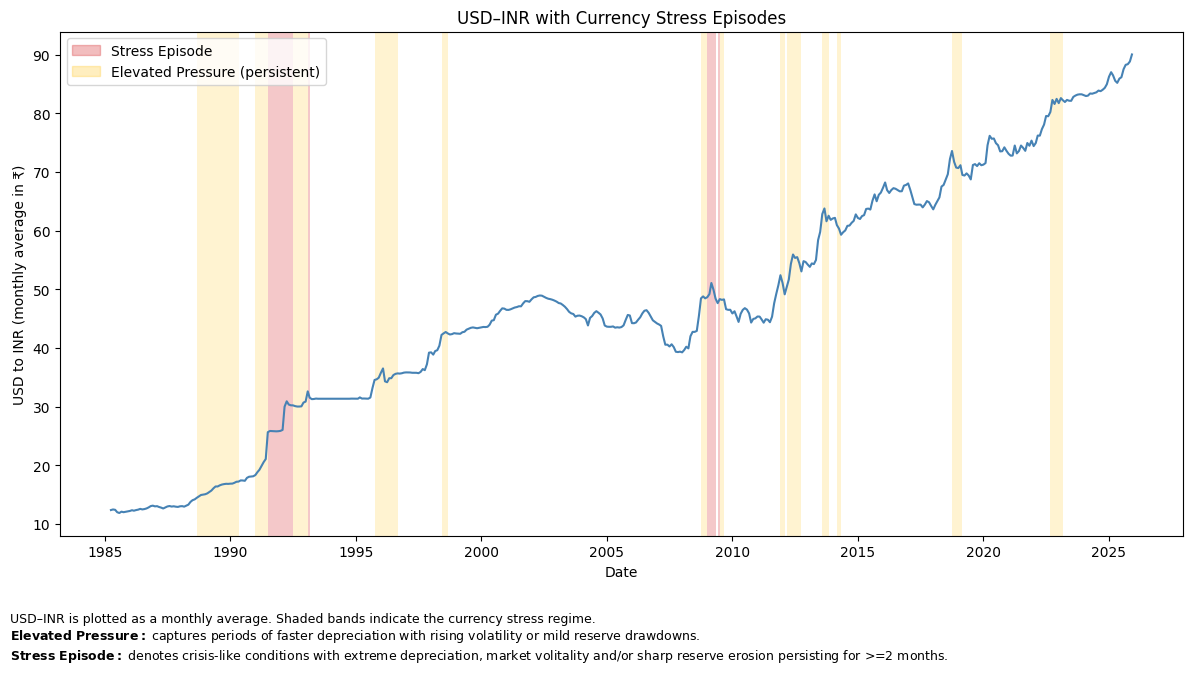

In [58]:
sig = sig.copy()
sig["date"] = pd.to_datetime(sig["date"], dayfirst=True)
sig = sig.sort_values("date").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 6))
#usd inr line
ax.plot(sig["date"], sig["fx_rate"], color="steelblue", linewidth=1.5)

#extreme stress block
is_stress = sig["stress_regime"] == 2
stress_start = is_stress & ~is_stress.shift(1, fill_value=False)
episode_id = stress_start.cumsum()
episode_id = episode_id.where(is_stress, np.nan)

tmp = sig.copy()
tmp["episode_id"] = episode_id

episodes = (
    tmp.dropna(subset=["episode_id"])
       .groupby("episode_id")
       .agg(start=("date", "min"), end=("date", "max"))
)

for _, r in episodes.iterrows():
    ax.axvspan(
        r["start"],
        r["end"] + pd.offsets.MonthBegin(1),
        color="#d62728",
        alpha=0.25,
        linewidth=0
    )

#elevated pressure block (only if persists for >=2 months)
is_elev = sig["stress_regime"] == 1
elev_start = is_elev & ~is_elev.shift(1, fill_value=False)
elev_id = elev_start.cumsum()
elev_id = elev_id.where(is_elev, np.nan)

tmp["elev_id"] = elev_id

elev_eps = (
    tmp.dropna(subset=["elev_id"])
       .groupby("elev_id")
       .agg(start=("date", "min"), end=("date", "max"), months=("date", "count"))
)

for _, r in elev_eps.iterrows():
    if r["months"] >= 2:   # persistence filter
        ax.axvspan(
            r["start"],
            r["end"] + pd.offsets.MonthBegin(1),
            color="#ffbf00",
            alpha=0.18,
            linewidth=0
        )

ax.set_title("USD–INR with Currency Stress Episodes")
ax.set_xlabel("Date")
ax.set_ylabel("USD to INR (monthly average in ₹)")

legend_patches = [
    mpatches.Patch(color="#d62728", alpha=0.30, label="Stress Episode"),
    mpatches.Patch(color="#ffbf00", alpha=0.25, label="Elevated Pressure (persistent)"),
]
ax.legend(handles=legend_patches, loc="upper left")

caption = (    
    "USD–INR is plotted as a monthly average. Shaded bands indicate the currency stress regime."
    "\n"
    r"$\mathbf{Elevated\ Pressure:}$ captures periods of faster depreciation with rising volatility or mild reserve drawdowns."
    "\n"
    r"$\mathbf{Stress\ Episode:}$ denotes crisis-like conditions with extreme depreciation, market volitality and/or sharp reserve erosion persisting for >=2 months."
)

fig.text(0.01, -0.03, caption, ha="left", va="top", fontsize=9)

plt.tight_layout()
plt.show()

In [59]:
print(sig.columns.tolist())


['date', 'inr_dep_12m', 'fx_vol_12m', 'fx_reserves', 'reserves_12m_change', 'fx_rate', 'pace_stress', 'vol_stress', 'buf_stress', 'stress_flag', 'stress_start', 'episode_id', 'pace_elev', 'pace_ext', 'vol_elev', 'vol_ext', 'buf_elev', 'buf_ext', 'stress_regime']


In [60]:
s = sig["inr_dep_12m"].dropna()
print("Mean:", round(s.mean(), 3))
print("Median:", round(s.median(), 3))
print("p75:", round(np.percentile(s, 75), 3))
print("p95:", round(np.percentile(s, 95), 3))
print("Latest:", round(s.iloc[-1], 3))


Mean: 0.055
Median: 0.038
p75: 0.087
p95: 0.209
Latest: 0.06


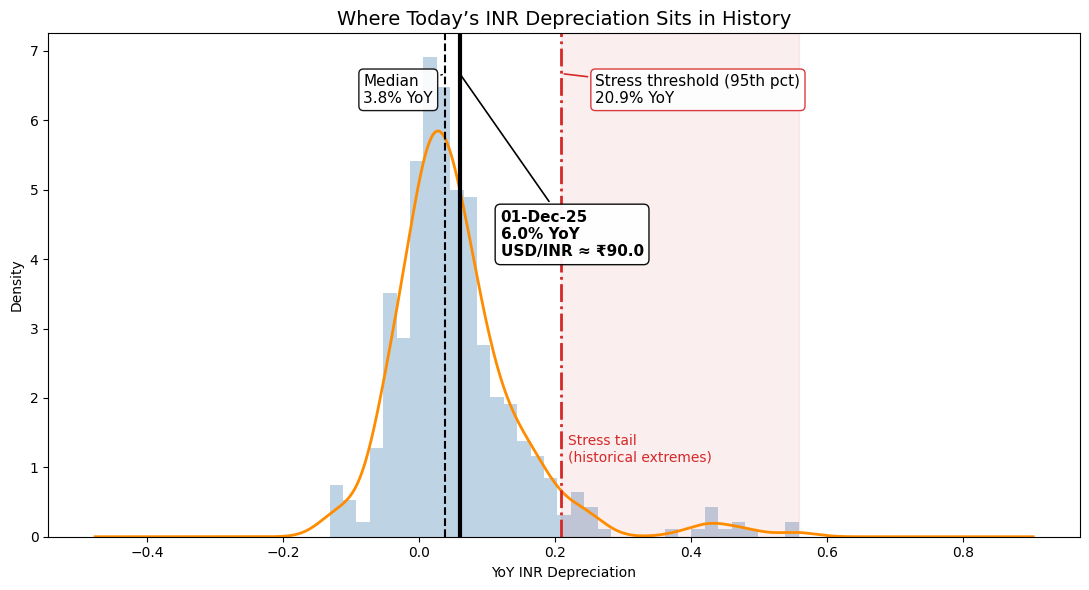

In [61]:
s = sig["inr_dep_12m"].dropna()

latest_row = sig.dropna(subset=["inr_dep_12m"]).iloc[-1]
latest = float(latest_row["inr_dep_12m"])
latest_date = pd.to_datetime(latest_row["date"]).strftime("%d-%b-%y")

latest_fx = float(latest_row["fx_rate"]) if "fx_rate" in latest_row else np.nan

median = float(s.median())
p95 = float(np.percentile(s, 95))

fig, ax = plt.subplots(figsize=(11, 6))

# Histogram + KDE
ax.hist(s, bins=35, density=True, color="steelblue", alpha=0.35)
s.plot(kind="kde", color="darkorange", linewidth=2, ax=ax)

# Stress tail
ax.axvspan(p95, s.max(), color="#d62728", alpha=0.08)

# markers
ax.axvline(median, color="black", linestyle="--", linewidth=1.5)
ax.axvline(p95, color="#d62728", linestyle="-.", linewidth=2)
ax.axvline(latest, color="black", linewidth=3)

ax.set_title("Where Today’s INR Depreciation Sits in History", fontsize=14)
ax.set_xlabel("YoY INR Depreciation")
ax.set_ylabel("Density")

ymax = ax.get_ylim()[1]
label_y = ymax * 0.92

# annotations
ax.annotate(
    f"Median\n{median:.1%} YoY",
    xy=(median, label_y),
    xytext=(median - 0.12, label_y),
    textcoords="data",
    ha="left", va="top",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9),
    arrowprops=dict(arrowstyle="-", color="black", lw=1)
)

ax.annotate(
    f"Stress threshold (95th pct)\n{p95:.1%} YoY",
    xy=(p95, label_y),
    xytext=(p95 + 0.05, label_y),
    textcoords="data",
    ha="left", va="top",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#d62728", alpha=0.9),
    arrowprops=dict(arrowstyle="-", color="#d62728", lw=1.2)
)

latest_label = f"{latest_date}\n{latest:.1%} YoY"
if not np.isnan(latest_fx):
    latest_label += f"\nUSD/INR ≈ ₹{latest_fx:.1f}"

ax.annotate(
    latest_label,
    xy=(latest, label_y),
    xytext=(latest + 0.06, ymax * 0.65),
    textcoords="data",
    ha="left", va="top",
    fontsize=11,
    fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="black", alpha=0.95),
    arrowprops=dict(arrowstyle="-", color="black", lw=1.2)
)

ax.text(
    p95 + 0.01,
    ymax * 0.15,
    "Stress tail\n(historical extremes)",
    color="#d62728",
    fontsize=10
)

plt.tight_layout()
plt.show()


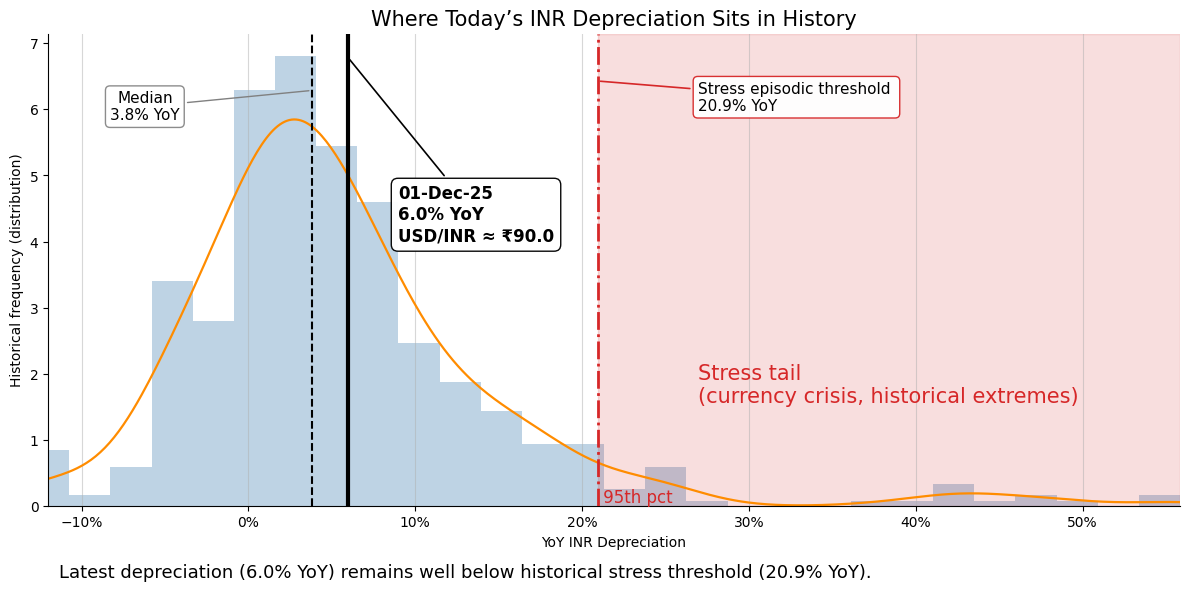

In [62]:
s = sig["inr_dep_12m"].dropna()

latest_row = sig.dropna(subset=["inr_dep_12m"]).iloc[-1]
latest = float(latest_row["inr_dep_12m"])
latest_date = pd.to_datetime(latest_row["date"]).strftime("%d-%b-%y")
latest_fx = float(latest_row["fx_rate"]) if "fx_rate" in sig.columns else np.nan

median = float(s.median())
p95 = float(np.percentile(s, 95))

# histogram + KDE
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(s, bins=28, density=True, color="steelblue", alpha=0.35)
s.plot(kind="kde", color="darkorange", linewidth=1.6, ax=ax)

xmin = max(float(s.min()), -0.25)   
xmax = max(float(s.max()), p95 + 0.25)
ax.set_xlim(xmin, xmax)
ax.grid(axis="x", alpha=0.5)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.axvspan(p95, ax.get_xlim()[1], color="#d62728", alpha=0.08)


# stress tail
ax.axvspan(p95, float(s.max()), color="#d62728", alpha=0.08)

# markers
ax.axvline(median, color="black", linestyle="--", linewidth=1.5, zorder=3)
ax.axvline(p95, color="#d62728", linestyle="-.", linewidth=2.0, zorder=3)
ax.axvline(latest, color="black", linewidth=3.0, zorder=4)

ax.set_title("Where Today’s INR Depreciation Sits in History", fontsize=15)
ax.text(
    0.01, -0.15,
    f"Latest depreciation ({latest:.1%} YoY) remains well below historical stress threshold ({p95:.1%} YoY).",
    transform=ax.transAxes,
    fontsize=13
)

ax.set_xlabel("YoY INR Depreciation")
ax.set_ylabel("Historical frequency (distribution)")

ax.text(p95, 0, " 95th pct", color="#d62728", fontsize=12,
        transform=ax.get_xaxis_transform(), va="bottom")

ymax = ax.get_ylim()[1]
ax.set_xlim(-0.12, ax.get_xlim()[-1])

# annotations
ax.annotate(
    f"Median\n{median:.1%} YoY",
    xy=(median, ymax * 0.88),
    xytext=(median - 0.10, ymax * 0.88),
    ha="center", va="top",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="grey", alpha=0.9),
    arrowprops=dict(arrowstyle="-", color="grey", lw=1.0)
)

ax.annotate(
    f"Stress episodic threshold \n{p95:.1%} YoY",
    xy=(p95, ymax * 0.90),
    xytext=(p95 + 0.06, ymax * 0.90),
    ha="left", va="top",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#d62728", alpha=0.95),
    arrowprops=dict(arrowstyle="-", color="#d62728", lw=1.2)
)

latest_label = f"{latest_date}\n{latest:.1%} YoY"
if not np.isnan(latest_fx):
    latest_label += f"\nUSD/INR ≈ ₹{latest_fx:.1f}"

ax.annotate(
    latest_label,
    xy=(latest, ymax * 0.95),
    xytext=(latest + 0.03, ymax * 0.68),  
    ha="left", va="top",
    fontsize=12,
    fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.97),
    arrowprops=dict(arrowstyle="-", color="black", lw=1.2)
)

ax.text(
    p95 + 0.06,
    ymax * 0.22,
    "Stress tail\n(currency crisis, historical extremes)",
    color="#d62728",
    fontsize=15
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [63]:
monthly.columns.tolist()


['date',
 'fx_rate',
 'dxy',
 'us10y_nominal',
 'us10y_real',
 'fx_reserves',
 'inr_dep_12m',
 'dxy_indexed',
 'usd_inr_indexed',
 'usd_inr_12m',
 'dxy_12m',
 'quadrant',
 'reserves_idx',
 'usd_inr_idx',
 'reserves_12m_change',
 'inr_stress',
 'fx_logret',
 'fx_vol_12m']

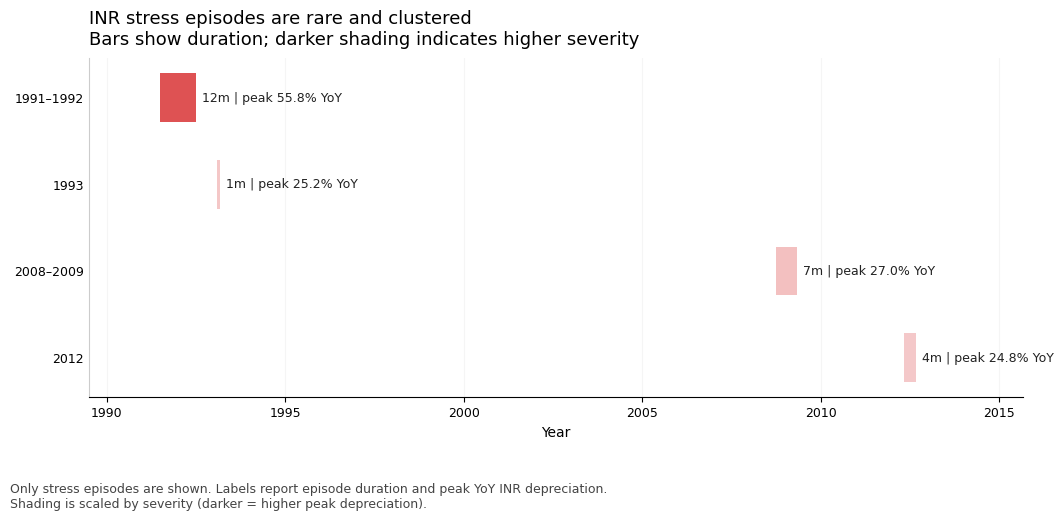

,start,end,months,peak_dep,peak_vol,min_res_yoy
0,1991-07-01,1992-06-01,12,0.558425,0.231460,-0.667408
1,1993-02-01,1993-02-01,1,0.252116,0.149804,0.306837
2,2008-10-01,2009-04-01,7,0.269924,0.094826,-0.203683
3,2012-05-01,2012-08-01,4,0.247772,0.098976,-0.099426


In [75]:
# final plot 3: stress episodes

## redefining variables
sig = monthly[["date", "inr_dep_12m", "fx_vol_12m", "reserves_12m_change"]].copy()
sig["date"] = pd.to_datetime(sig["date"], dayfirst=True, errors="coerce")
sig = sig.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

pace_p95 = np.nanpercentile(sig["inr_dep_12m"], 95)
vol_p90  = np.nanpercentile(sig["fx_vol_12m"], 90)

sig["pace_stress"] = sig["inr_dep_12m"] >= pace_p95
sig["vol_stress"]  = sig["fx_vol_12m"]  >= vol_p90
sig["buf_stress"]  = sig["reserves_12m_change"] <= 0

sig["stress_flag"] = sig["pace_stress"] & (sig["vol_stress"] | sig["buf_stress"])

sig["stress_start"] = sig["stress_flag"] & ~sig["stress_flag"].shift(1, fill_value=False)
sig["episode_id"]   = sig["stress_start"].cumsum()
sig.loc[~sig["stress_flag"], "episode_id"] = np.nan

episodes = (
    sig.dropna(subset=["episode_id"])
      .groupby("episode_id")
      .agg(
          start=("date", "min"),
          end=("date", "max"),
          months=("date", "count"),
          peak_dep=("inr_dep_12m", "max"),
          peak_vol=("fx_vol_12m", "max"),
          min_res_yoy=("reserves_12m_change", "min"),
      )
      .sort_values("start")
)

if episodes.empty:
    raise ValueError("No stress episodes found. Check thresholds or inputs.")

# plot 3
fig, ax = plt.subplots(figsize=(10.8, 4.6))

sev = episodes["peak_dep"].to_numpy(dtype=float)
if np.isfinite(sev).sum() >= 2 and np.nanmax(sev) > np.nanmin(sev):
    sev_norm = (sev - np.nanmin(sev)) / (np.nanmax(sev) - np.nanmin(sev))
else:
    sev_norm = np.full_like(sev, 0.5)

alphas = 0.25 + 0.55 * sev_norm

episodes_plot = episodes.copy()
episodes_plot["end_vis"] = episodes_plot["end"] + pd.offsets.MonthBegin(1)

y = np.arange(len(episodes_plot))[::-1]
bar_h = 0.56

xmin = episodes_plot["start"].min() - pd.DateOffset(years=2)
xmax = episodes_plot["end_vis"].max() + pd.DateOffset(years=3)

for i, (_, r) in enumerate(episodes_plot.iterrows()):
    start, end = r["start"], r["end_vis"]
    left = mdates.date2num(start)
    width = mdates.date2num(end) - left

    ax.broken_barh(
        [(left, width)],
        (y[i] - bar_h/2, bar_h),
        facecolors="tab:red",
        edgecolor="none",
        alpha=float(alphas[i]),
        zorder=2
    )

    txt = f"{int(r['months'])}m | peak {r['peak_dep']:.1%} YoY"
    ax.text(end + pd.Timedelta(days=60), y[i], txt, va="center", fontsize=9, color="#222222")

yt = []
for r in episodes_plot.itertuples():
    yt.append(f"{r.start.year}" if r.start.year == r.end.year else f"{r.start.year}–{r.end.year}")
ax.set_yticks(y)
ax.set_yticklabels(yt, fontsize=9)

ax.set_xlim(xmin, xmax)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set_title(
    "INR stress episodes are rare and clustered\n"
    "Bars show duration; darker shading indicates higher severity",
    loc="left",
    fontsize=13,
    pad=10
)
ax.set_xlabel("Year")

ax.grid(axis="x", alpha=0.12, zorder=1)
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", labelsize=9)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(True)
ax.spines["left"].set_color("#cccccc")
ax.spines["left"].set_linewidth(0.8)

caption = (
    "Only stress episodes are shown. "
    "Labels report episode duration and peak YoY INR depreciation.\n"
    "Shading is scaled by severity (darker = higher peak depreciation)."
)
fig.text(0.01, -0.06, caption, ha="left", va="top", fontsize=9, color="#444444")

plt.tight_layout()
plt.show()

episodes.reset_index(drop=True)


In [65]:
episodes.columns.tolist()


['start', 'end', 'months', 'peak_dep', 'peak_vol', 'min_res_yoy']

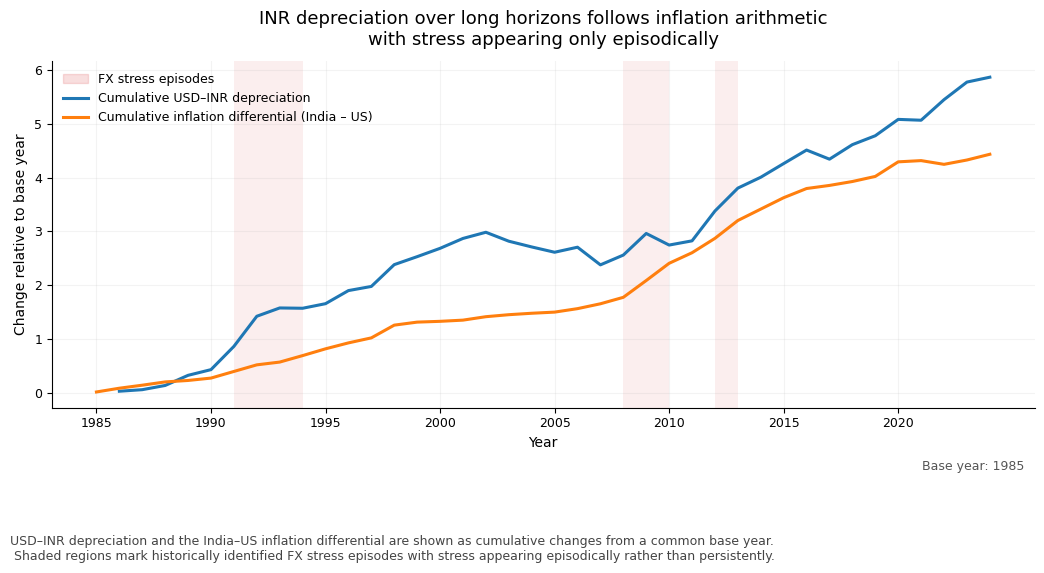

In [66]:
## final plot 4: inflatiion diff and usd-inr with stress periods highlighted 


fig, ax = plt.subplots(figsize=(10.5, 5))

for _, row in episodes.iterrows():
    ax.axvspan(
        row["start"].year,
        row["end"].year + 1,   # include end year visually
        color="tab:red",
        alpha=0.08,
        linewidth=0
    )

ax.plot(
    annual["year"],
    annual["cum_inr_dep"],
    linewidth=2.2,
    label="Cumulative USD–INR depreciation"
)

ax.plot(
    annual["year"],
    annual["cum_inflation_diff"],
    linewidth=2.2,
    label="Cumulative inflation differential (India – US)"
)
ax.set_title(
    "INR depreciation over long horizons follows inflation arithmetic\n"
    "with stress appearing only episodically",
    loc="center",
    fontsize=13,
    pad=12
)
ax.set_xlabel("Year")
ax.set_ylabel("Change relative to base year")  

ax.grid(alpha=0.15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# X ticks every 5 years
years = annual["year"].dropna().astype(int)
start, end = years.min(), years.max()
ax.set_xticks(list(range((start//5)*5, end+1, 5)))

stress_patch = mpatches.Patch(
    color="tab:red",
    alpha=0.15,
    label="FX stress episodes"
)

ax.legend(
    handles=[stress_patch] + ax.get_lines(),
    frameon=False,
    loc="upper left",
    fontsize=9
)


caption = (
    "USD–INR depreciation and the India–US inflation differential are shown as cumulative changes from a common base year.\n "
    "Shaded regions mark historically identified FX stress episodes with stress appearing episodically rather than persistently."
)

fig.text(
    0.01, -0.08,
    caption,
    ha="left",
    va="top",
    fontsize=9,
    color="#444444"
)


ax.text(
    0.99, -0.18,
    f"Base year: {start}",
    transform=ax.transAxes,
    ha="right",
    fontsize=9,
    color="#555555"
)
ax.tick_params(axis="both", labelsize=9)


plt.tight_layout()
plt.show()


In [67]:
sig.columns.tolist()

['date',
 'inr_dep_12m',
 'fx_vol_12m',
 'reserves_12m_change',
 'pace_stress',
 'vol_stress',
 'buf_stress',
 'stress_flag',
 'stress_start',
 'episode_id']

In [68]:
sig = sig.merge(
    monthly[["date","fx_rate"]],
    on="date",
    how="left"
)

In [69]:
sig.columns.tolist()

['date',
 'inr_dep_12m',
 'fx_vol_12m',
 'reserves_12m_change',
 'pace_stress',
 'vol_stress',
 'buf_stress',
 'stress_flag',
 'stress_start',
 'episode_id',
 'fx_rate']

In [70]:
sig["date"]

0     1985-04-01
1     1985-05-01
2     1985-06-01
3     1985-07-01
4     1985-08-01
         ...    
484   2025-08-01
485   2025-09-01
486   2025-10-01
487   2025-11-01
488   2025-12-01
Name: date, Length: 489, dtype: datetime64[ns]

In [71]:
episodes.columns.tolist()

['start', 'end', 'months', 'peak_dep', 'peak_vol', 'min_res_yoy']

In [72]:
episodes["peak_dep"]

episode_id
1.0    0.558425
2.0    0.252116
3.0    0.269924
4.0    0.247772
Name: peak_dep, dtype: float64